In [2]:
# preamble

# set up environments base -> ATOMIC_GOES
# IJulia and Revise must be installed in the Julia base @version package environment.
# Sometimes perhaps an vscode extension
using Revise # does using Revise first allow for revising code in ATOMIC_GOES???
using Pkg
# Pkg.activate(joinpath(homedir(), "Projects/ATOMIC/ATOMIC_GOES/julia/ATOMIC_GOES"))
Pkg.activate(".")

# using ATOMIC_GOES
# using ATOMIC_GOES.DataIO

using Printf
# using FileIO
using Dates
using NCDatasets
using JLD2

# using StatsBase
using ForwardDiff
using Statistics
using Interpolations
# using DSP

using PyPlot
# using PyCall
# using CSV

  Activating project at `~/Projects/ATOMIC/trade-cu-model/src/julia`


In [3]:
# utility functions; extend matplotlib

# use numpy masking for missing
using PyCall
using PyCall: PyObject

# allow for plotting with missing values
function PyCall.PyObject(a::Array{Union{T,Missing},N}) where {T,N}
    numpy_ma = PyCall.pyimport("numpy").ma
    pycall(numpy_ma.array, Any, coalesce.(a,zero(T)), mask=ismissing.(a))
end

"plotf(f, x, args...)  function plot wrapper"
plotf(f, x, args...) = plot(f.(x), x, args...)

pd = permutedims

"midpoint averager"
mid(x) = 0.5*(x[1:end-1].+x[2:end]) # doesn't work for Int16

"missing to zero"
# m2z(x) = ismissing(x) ? 0 : x
m2z(x) = replace(x, missing=>0)

# statistics fcns
"anomaly"
anom(r, kwargs...) = r .- mean(r, kwargs...)

"runningmean(x, n=7, f=isfinite) n-point running mean points satisfying f(x)==true"
function runningmean(x, n=7, f=isfinite)
    notf2zero(x) = f(x) ? x : 0
    cs = cumsum(notf2zero.(x))
    ct = cumsum(f.(x))
    (cs[n+1:end] .- cs[1:end-n]) ./ (ct[n+1:end] .- ct[1:end-n])
end

recurse(f, x, n) = n>0 ? f(recurse(f, x, n-1)) : x
"abstractly composes f n times; recursef(f,3) = f∘f∘f = x->f(f(f(x))), without evaluating"
recursef(f,n) = reduce(∘, ntuple(_ -> f, n)) 

"declare arrays with elements of Union{Missing,T} unions"
similarmissing(s::Tuple, T::Type=Float64) = Array{Union{Missing, T}}(missing, s)
similarmissing(A::Array) = similarmissing(size(A), eltype(A))

"moving_average(A, m) m-point moving average of A"
function moving_average(A::AbstractArray, m::Int, cond=x->true)
    out = similar(A)
    R = CartesianIndices(A)
    Ifirst, Ilast = first(R), last(R)
    I1 = m÷2 * oneunit(Ifirst)
    for I in R
        n, s = 0, zero(eltype(out))
        for J in max(Ifirst, I-I1):min(Ilast, I+I1)
            if cond(A[J]) # add condition, e.g. isfinite
                s += A[J]
                n += 1
            end
        end
        out[I] = s/n
    end
    return out
end

# means and helper functions

n2m(x) = isnan(x) ? missing : x
skipnan(x) = skipmissing(n2m.(x))

"upsample by factor n, between 2 points"
upsample1(x0, x1; n=10, a=(0:n)/n) = x0*(1-a) + x1*a

"upsample X by factor n, between points of vector x."
function upsample(x; n=10, a=(0:n)/n)
    X = zeros((length(x)-1)*n + 1)
    for i in eachindex( x[1:end-1] )
        X[n*(i-1)+1 .+ (0:n)] .= x[i]*(1 .- a) + x[i+1]*a
    end
    X
end

"\\xi(x) wrapper for upsampling linearly in log space"
ξ(x) = exp.(upsample(log.(x))) # 

ξ

In [4]:
module VaporSat

using ForwardDiff

export qsat, dqsdT, dlnqsdT
export Twet_autodiff

# constants
Cp = 1005.7  # from my Davies-Jones function, was 1005.
Cpv = 1870.0 # J/kg/K
Cw  = 4190.0
L0 = 2.501e6 # J/kg

C = 273.15 # K
Rd = 287.04
Rv = 461.5
RdoRv=Rd/Rv

grav = 9.8 # m/s2

"latent heat of water vapor"
LvK(TempK) = L0 + (Cpv-Cw) * (TempK-273.0)

# functions
"""
es(T,p) = is saturation vapor pressure based on Wexler's formula,
with enhancement factor for moist air rather than water vapor.
The enhancement factor requires a pressure.
T [degrees C], p [Pa] (note the reversed input order), es [Pa]
Calling with optional keywords changes the units and
ignores the positional arguments.
es(T,p; TK=tk[Kelvin], P=pr[hPa])
From A. L. Buck 1981: JAM, 20, 1527-1532.
SPdeS 7 July 2004
"""
function es(T,p=1e5; P=p*1e-2)
    esat = 1e2 * 6.1121*(1.0007 + 3.46e-8*P)*exp((17.502*T)/(240.97 + T)) # convert es to Pa
end

"T [C]; supplying TK [Kelvin] by keyword ignores positional T"
function es(T,p=1e5; TK=T+C, P=p*1e-2)
    T = TK - C
    esat = 1e2 * 6.1121*(1.0007 + 3.46e-8*P)*exp((17.502*T)/(240.97 + T)) # converts es to Pa
end

"""
qsat(p,T) is saturation specific humidity based on Wexler's formula for es
with enhancement factor (see es.m).
p [Pa], T [degrees C], qsat [kg/kg]
From A. L. Buck 1981: JAM, 20, 1527-1532.
SPdeS 7 July 2004
"""
qsat(p,T) = RdoRv*es(T,p) / (p + (RdoRv-1)*es(T,p))

"dqsdT(p,T[C]) derivative of qsat with respect to T at p,T by autodiff of Bolton's qsat"
dqsdT(p,T) = ForwardDiff.derivative(t -> qsat(p,t), T)
dlnqsdT(p,T) = ForwardDiff.derivative(t -> log(qsat(p,t)), T)

# wet bulb temperature methods
# for approximating the evap process

"General single Newton iteration to update x toward f(x) = fhat for a univariate function f"
updatex(f, x, fhat) = x + (fhat-f(x)) / ForwardDiff.derivative(f, x)

"""
Twet_autodiff(T[K], q[kg/kg], p[Pa]; niter=2) wet bulb temperature using Newton's method
for target specific humidity q[kg/kg]. Uses automatic differntiation.
"""
function Twet_autodiff(T, q, p; niter=2)
    b(t) = f(t) = (t - T) + LvK((T+t)/2)/Cp * (qs(p,t-C) - q)
    t=T
    for i in 1:niter
        t = updatex(f, t, 0)
    end
    t
end
# 2 iterations converges to ~0.001 K

# call as...
# q = rh*qsat(pa, Ta)
# Twet_autodiff(Ta, rh*qsat(pa, Ta-C), pa) 

#=
# dew point temperature
function dewpoint_from_q_buck1981(q, P=101325.0)
    # Convert specific humidity to vapor pressure
    e = (q * P) / (0.622 + 0.378 * q)
    
    # Invert Buck (1981): es = 611.21 * exp((18.678 - T/234.5) * (T / (257.14 + T)))    
    b = log(e / 611.21)
    Td = (257.14 * b) / (18.678 - b)
end
=#

# integrate pressure from the hydrostatic equation
dlnp(Tv, dz) = -gravity * dz / (Rd * Tv)
press_hydrostatic(Tv, dz, p0) = p0 * exp(cumsum(dlnp(Tv, dz)))

# reference pressure [Pa] profile
p_q(Tm) = interpolate((Tm,), press_hydrostatic.((1+(1/RdoRv-1)*qm)*Tm, dz, p0))

"""Tcond_autodiff(T[K], q[kg/kg], p[Pa]; niter=2) 
Temperature at which condensation likely occurred 
for target specific humidity q[kg/kg] and reference pressure p[Pa].
Uses automatic differentiation.
"""
function Tcond_autodiff(q; niter=5, tol=1e-2)
    f(t) = p_q(t)/esat(t-C) - (RdoRv*(1/q - 1) + 1)
    t = 280.0 # first guess
    for i in 1:niter
        tmp = updatex(f, t, 0)
        if abs(tmp - t) < tol
            t = tmp
            break
        end
        t = tmp
    end
    t
end

end # module VaporSat

┌ Warning: Replacing docs for `Main.VaporSat.es :: Union{Tuple{Any}, Tuple{Any, Any}}` in module `Main.VaporSat`
└ @ Base.Docs docs/Docs.jl:249


Main.VaporSat

In [5]:
# functions for thermodynamics

using .VaporSat
# exports dqsdT, qsat
# overloads some unexported methods in VaporSat

# constants
Rd=287.04 # J/K/kg Bolton
Cp=1005.7 # J/K/kg Bolton
Rv=461.5 # Bolton
# specific heats of vapor and liquid
Cpv=1870 # Bolton
Cw=4190  # Bolton
gravity=9.8 #
KelvinCelsius=273.15 # K


# Lv(T) = 2.501e6 + (Cpv-Cw) * T # Celsius
"Lv(T) [J/kg] Latent heat of vaporization of water as a function of temperature [K]."
Lv(T) = 2.501e6 + (Cpv-Cw) * (T-KelvinCelsius)
LvK(T) = Lv(T-273.15)

"""
qv(p/ev) = Rd / (Rv * (p/ev + (Cp/Rv-1)))
specific humidity [kg/kg]
"""
qv(poev) = Rd / (Rv * (poev + (Cp/Rv-1.)))
qv(p,ev) = qv(p/ev)

"vapor pressure in units of p, qv unitless"
ev(p, qv) = p*qv / (Rd/Rv + qv)

"""
esat(T,p) [hPa] computes saturation vapor pressure based on Wexler's formula,
with enhancement factor for moist air rather than water vapor.
The enhancement factor requires a pressure.
T [degrees C], p [hPa] (note the reversed input order), es [hPa]
From A. L. Buck 1981: JAM, 20, 1527-1532.
SPdeS 7 July 2004
"""
esat(T, p) = 6.1121*(1.0007 + 3.46e-8*p)*exp((17.502*T)/(240.97 + T))
#              hPa

# use method from VaporSat qsat(p[Pa], T[C])
# note order of arguments and units
# "qsat(T[C], p[hPa])"
# qsat(T, p) = qv(p/esat(T, p))

"specific humidity q [unitless] from mixing ratio w [unitless]"
q_from_w(w) = w/(1+w)

"""
Tlcl(T[K], ev[Pa])
Temperature at the LCL [K]. From Bolton, 1980, MWR, 108, 1046-1053.
"""
Tlcl(T, ev) = 2840. / (3.5*log(T) - log( 0.01*ev ) - 4.805) + 55.

# adiabatic lapse rate
lapse_ad = gravity/Cp

"moist adiabatic lapse rate p[Pa], T[K]"
lapse_moist(T,p) = lapse_ad * (1 + Lv(T)*qsat(p,T-KelvinCelsius)/(Rd*T)) / (1 + Lv(T)^2*Rd/Rv*qsat(p,T-KelvinCelsius)/(Rd*Cp*T*T))
# lapse_moist(T,p) = lapse_ad * (1 + Lv(T)*qsat(T-273.0,p)/(Rd*T)) / (1 + Lv(T)^2*Rd/Rv*qsat(T-273.0,p)/(Rd*Cp*T*T))

"parcel process adiabatic change in saturation vapor pressure, p[Pa], T[K]"
dqsatdz_moistad(p,T) = dqsdT(p,T-KelvinCelsius) * -lapse_moist(T,p) # negative
# Small inconsistencies between dqsdT (Bolton) 
# and lapse_moist (Rogers and Yau) methods
# are OK here.

"density temperature for liquid water loading (exact, or take default approximation)"
liqldfac(ql; rhoa_o_rhoL=0.001) = 1 - (1 - rhoa_o_rhoL) * ql
Tliqld(Tv, ql; p=1e5, rhoa=p/(Rd*Tv)) = Tv * liqldfac(ql; rhoa_o_rhoL=rhoa/1000.0)

Tliqld (generic function with 1 method)

In [6]:
# load data

# prefixer() = startswith(gethostname(), "sundog") ? "/mnt/c" : "/"
# datapath = joinpath(prefixer(), "Users/deszoeks/Data/ATOMIC/radiosonde/level2")
datapath = "../../data/flux"

# PSL flux data file
# EUREC4A_ATOMIC_RonBrown_10min_nav_met_sea_flux_20200109-20200212_v1.3.nc
psl = NCDataset(joinpath(datapath, "EUREC4A_ATOMIC_RonBrown_10min_nav_met_sea_flux_20200109-20200212_v1.3.nc"))
# mean(skipmissing(psl["hl_bulk"][:]))
# mean(skipmissing(psl["prate"][:])) # 0.031 mm/h

# E0 = -mean(skipmissing(psl["hl_bulk"][:])) # 180 W/m^2
# P0 = rhosfc*L * mean(skipmissing(psl["prate"][:])) / 3600 # W/m^2

# sondes data file
datapath = joinpath(homedir(),"Data/ATOMIC/radiosonde/level2")
# readdir(datapath)
ncfile = filter(x-> startswith(x,"EUREC4A_RonBrown") && endswith(x,"Vaisala-RS_L2_v3.0.0.nc"), readdir(datapath))
ds = NCDataset( joinpath(datapath, ncfile[1]) )

ds[:alt][:] # 3100, 10-m vert resolution
ds[:ta][:,:] # 3100×277 Matrix{Union{Missing, Float32}}
# p(sounding, alt) ;
# lat(sounding, alt) ;
# lon(sounding, alt) ;
# dz(sounding, alt) ;
# ta(sounding, alt) ;
# dp(sounding, alt) ;
# wspd(sounding, alt) ;
# u(sounding, alt) ;
# v(sounding, alt) ;
# mr(sounding, alt) ;
# theta(sounding, alt) ;
# q(sounding, alt) ;
# wdir(sounding, alt) ;
# rh(sounding, alt) ;
# N_ptu(sounding, alt) ;
# N_gps(sounding, alt) ;

# ncdump -h EUREC4A_Atalante_Vaisala-RS_L2_v2.2.0.nc | grep -o -e "float \(\w*\)" | awk '{print $2}'
floatvars = split("p lat lon dz ta dp wspd u v mr theta q wdir rh N_ptu N_gps")

dsa = NCDataset("../../data/goes16_binned_low4km_20200115_20200219.nc")

Dataset: ../../data/goes16_binned_low4km_20200115_20200219.nc
Group: /

Dimensions
   time = 1192
   cth_bin = 351

Variables
  time   (1192)
    Datatype:    DateTime (Float64)
    Dimensions:  time
    Attributes:
     standard_name        = time
     units                = minutes since 2020-01-01
     calendar             = standard
     axis                 = T

  cth_bin   (351)
    Datatype:    Float64 (Float64)
    Dimensions:  cth_bin
    Attributes:
     axis                 = X

  cth_bins   (351)
    Datatype:    Union{Missing, Float64} (Float64)
    Dimensions:  cth_bin
    Attributes:
     _FillValue           = NaN
     missing_value        = NaN

  rfv_sum   (351 × 1192)
    Datatype:    Union{Missing, Float64} (Float64)
    Dimensions:  cth_bin × time
    Attributes:
     _FillValue           = NaN
     missing_value        = NaN

  bin_count   (351 × 1192)
    Datatype:    Float64 (Float64)
    Dimensions:  cth_bin × time

  rfv_nrm   (351 × 1192)
    Datatype:    Uni

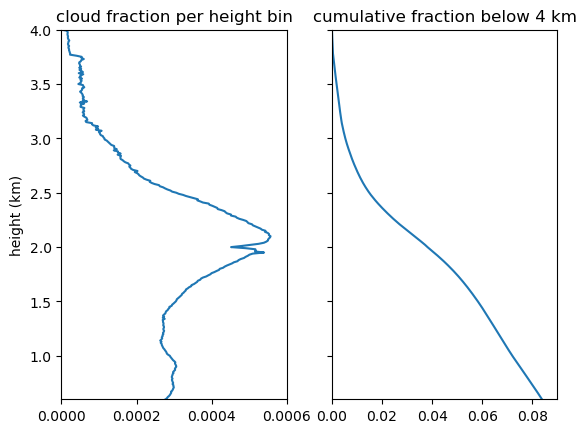

In [7]:
# plot mean cloud fraction vs. height data
rfv_nrm = mean(dsa[:rfv_nrm], dims=2)
rfv_acc = mean(dsa[:rfv_acc], dims=2)

fig, axs = subplots(1,2)

axs[1].plot(rfv_nrm, dsa[:cth_bin])
axs[1].set_title("cloud fraction per height bin")
axs[1].set_ylabel("height (km)")
axs[1].set_xlim([0, 6e-4])
axs[2].plot(rfv_acc, dsa[:cth_bin])
axs[2].set_xlim([0, 0.09])
axs[2].set_yticklabels((""))
axs[2].set_title("cumulative fraction below 4 km")
[ ax.set_ylim([0.6, 4]) for ax in axs ]
gcf()

# all( .≈(diff( dsa[:cth_bin][:] ), 0.01 ) ) # 10 m

In [8]:
"average all sounding times. preserve levels"
tmean(var, ds=ds) = [mean(skipmissing(ds[var][i,:])) for i in axes(ds[var][:,:],1)]

# get mean sounding data
z = ds[:alt][:]
tam = tmean(:ta) # K
thm = tmean(:theta)
qm  = tmean(:q)
pm  = tmean(:p) # Pa
qs  = qsat.(pm, tam.-KelvinCelsius) # kg/kg

tvm = tam .* (1 .+ 0.608*qm) # virtual temperature, K
#tdm = tvm # liqldfac(ql) # density temperature, K; no liquid water in env

3100-element Vector{Float64}:
 NaN
 NaN
 NaN
 NaN
 301.24035316388364
 301.12132369686776
 301.0095596774176
 300.9034356924022
 300.80359761428525
 300.7005503297537
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

In [9]:
# large scale profile for cloud & flux model

# vertical grid
z = ds[:alt][:]
ii = findall(isfinite.(qm))

zi = 3.0e3    # m
ztop = 4e3
# cloud base initial condition
zcb = 700
icb = findfirst(z .>= zcb) # cloud base index
qcb = qs[icb] # 0.0157
#Δq = qs .- qm # depends on environment only # different in paper text!

# derivatives
dz = 10.0 # z[2] - z[1]
dqdz  = diff(tmean(:q)) / dz
dqsdz = diff( qs      ) / dz
qm = tmean(:q)
z = ds[:alt][:]
ii = findall(isfinite.(qm))

# total large scale drying, add advection term in lower atm
divg = 1.0e-6 # 1/s

"large scale subsidence vertical velocity (m/s)"
subsidence(z; divg=divg, zi=zi) = -min(z,zi) * divg # <0
wdqdz = subsidence.(z[1:end-1]) .* dqdz
# ^ negate on rhs

# large scale source
S_ls = -wdqdz .- 1.7e-8*max.(0, (4e3.-z[1:end-1])/4e3) 

# vertical means over the cloud layer
Tmean = mean(skipnan(tmean(:ta)[ds[:alt].<=ztop])) # 286.6K = mean Cu layer temperature
pmean = mean(skipnan(tmean(:p)[ds[:alt].<=ztop]))
L = Lv(Tmean)
rhoL = pmean/(Rd*Tmean) * L

#=
E0 = -mean(skipmissing(psl["hl_bulk"][:])) # 180 W/m^2
P0 = rhosfc*L * mean(skipmissing(psl["prate"][:])) / 3600 # -> 25 W/m^2
=#

2.426927036481407e6

In [10]:
# compute total all-sky flux G with cloud base BC

# cloud base vapor flux initial condition
Ecb = 145 # E0 - 35; just the cloud vapor flux
Gcb = Ecb/rhoL - mean(skipmissing(psl["prate"][:])) / 3600 # _total_ flux F at cloud base
# F[icb] = Fcb # total flux at cloud base
# integrate total flux balancing subsidence
G = similarmissing(qm)
# A = -wdqdz .- 1.7e-8*max.(0, (4e3.-z[1:end-1])/4e3) # as above
G[icb:end] = Gcb .+ vcat(0, cumsum( S_ls[icb:end] ) * dz)

# icb = findfirst(.!ismissing.(F))
itop=lastindex(G)-1 

3099

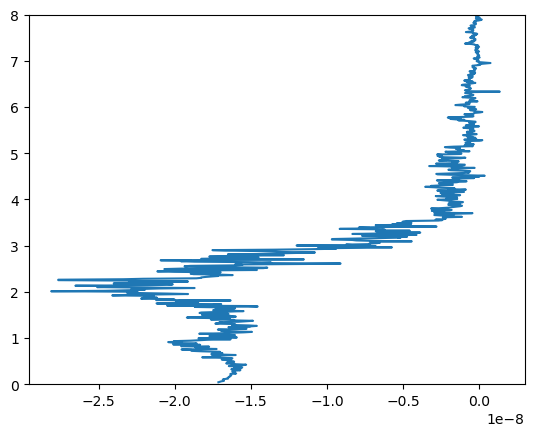

In [18]:
# plot G as a function of height
close("all")
plot(S_ls, z[1:end-1]/1e3)
# plot(G, z/1e3)
ylim([0, 8])
gcf()


## cloud ensemble, heights and area fractions

### Method 1, Horizontally uniform cloud eddy flux:
We distribute the all-sky mean flux G to the all-cloud mean 
$F=a_cld^{-1} G$, and then evenly to each cloud. If each cloud at level z has the same mean flux F_i (z)=F(z), then the all sky flux is
$$
G(z)=∑F_i (z)[a_i H(h_i-z)]=F(z)∑[a_i H(h_i-z)]=a_{cld}(z)F(z)
$$
with total cloud fraction at height z of 
$a_cld(z)=∑[a_i H(h_i-z)]$ and Heaviside function $H(x)={1,x≥0;0,x<0}$. As the flux decreases with height, there are fewer clouds to carry the mean flux.


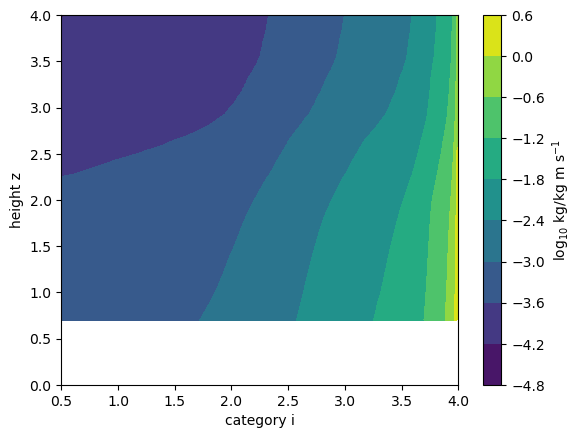

In [ ]:
sum(rfv_nrm) ≈ maximum(rfv_acc)
F1 = pd(G) ./ rfv_acc # dimension (category_i, z)

fig, ax = subplots(1,1)
contourf(dsa[:cth_bin], z[1:401]/1e3, log10.(pd(F1[:,1:401])))

xlabel("category i")
ylabel("height z")
colorbar(label="log\$_{10}\$ kg/kg m s\$^{-1}\$")
gcf()


### Method 2, Vertically uniform cloud eddy flux: 
The all-sky mean flux profile $G(z)$ has a flux difference at each height $h_i$ of $(ΔG)_i=G(h_{i+1})-G(h_i)$. This flux difference is assumed to be carried by the clouds with area fraction $a_i$ and height $h_i$, so the mean flux in cloud category $i$ is vertically uniform, 
$F_i=a_i^{-1} (ΔG)_i$.

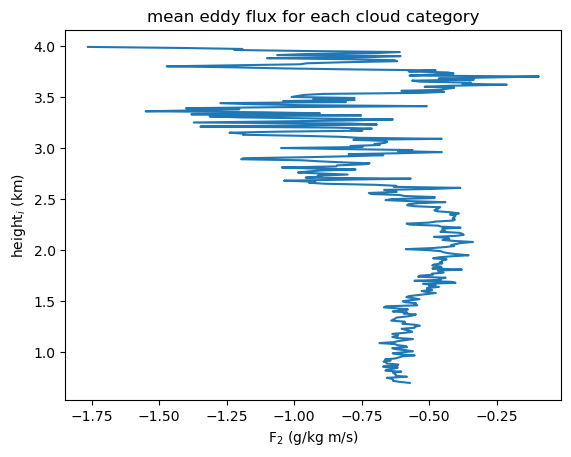

In [ ]:
ΔG = diff(G) # z grid
# need to line up bins
z[1:2] # m
dsa[:cth_bin][1:2]*1e3 # km -> m

offset = 50
z[offset] == dsa[:cth_bin][1]*1e3 # cth_bin starts at z=500
F2 = diff(G)[offset.+eachindex(rfv_nrm)] ./ rfv_nrm[:] # dimension category_i

figure()
# plot(cumsum(replace(F2, missing=>0)), dsa[:cth_bin])
plot(1e3*F2, dsa[:cth_bin])
title("mean flux balanced by each cloud category")
ylabel("height\$_i\$ (km)")
xlabel("F\$_2\$ (g/kg m/s)")
xlim([0, 1.75])
gcf()

In [116]:
F2

351-element Vector{Union{Missing, Float64}}:
    missing
    missing
    missing
    missing
    missing
    missing
    missing
    missing
    missing
    missing
   ⋮
  -0.0009595738806342714
  -0.0006925058779419859
  -0.0006092920947207993
  -0.0009559308498293967
  -0.0012216140909632547
  -0.0011918325557094282
  -0.0014210335099526764
  -0.0017635346344911562
 -Inf